# Cell Area

## Autogenerated Report: EPIC Cell Area Analysis
#### Website: https://github.com/AlphonsG/EPIC-BBox-Cell-Tracking

In [1]:
import math 
import shutil
import sys
import os
import csv
from collections import defaultdict
from copy import deepcopy
from itertools import chain
import random as rd
from statistics import mean, pstdev

import cv2

from IPython.display import Image, Video, display

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import scipy 

import epic
from epic.analysis.cell_migration_analysis import (drnty_vs_euclid_dist,
                                                   metric_box_plots, metric_mthd_avgs,
                                                   smp_trks_le_dist, smp_trks_le_propn, 
                                                   smp_trks_len, traj_plots)
from epic.analysis.cell_migration_metrics import MetricFactory
from epic.utils.cell_migration import detect_leading_edges
from epic.detection.deep_extreme_cut import DeepExtremeCut
from epic.utils.file_processing import (load_imagej_tracks, load_imgs,
                                        load_motc_dets, load_motc_tracks,
                                        save_imgs, save_motc_tracks, save_video,
                                        video_reshape)
from epic.utils.image_processing import (draw_bounding_boxes, draw_masks, draw_ids, draw_leading_edges, 
                                         draw_tracks)
from epic.utils.misc import create_tracklets

In [2]:
# preconfiguration
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100
rd.seed(0)
DPI = 1000
VID_FILENAME = 'video'
CELL_AREAS_FIG_FILENAME = 'organoid_swelling_over_time.png'
CELL_AREAS_NORM_FIG_FILENAME = 'organoid_swelling_over_time_normalized.png'
AUC_CSV_FILENAME = 'organoid_swelling_area_under_the_curve.csv'
AUC_NORM_CSV_FILENAME = 'organoid_swelling_area_under_the_curve_normalized.csv'
AUC_FIG_FILENAME = 'organoid_swelling_area_under_the_curve.png'
AUC_NORM_FIG_FILENAME = 'organoid_swelling_area_under_the_curve_normalized.png'

In [3]:
# start
cwd = os.getcwd()

## Image Series

In [4]:
# load images
motchallenge_img_dir = os.path.join(cwd, '..', 'img1')
img_dir = (motchallenge_img_dir if os.path.isdir(motchallenge_img_dir) else 
           os.path.join(cwd, '..'))
assert os.path.isdir(img_dir), f'Image directory {img_dir} could not be found.'
imgs = load_imgs(img_dir) 
assert len(imgs) > 1, 'Raw image series shorter than 2 frames.'
print(f'Loaded {len(imgs)} images.')

Loaded 6 images.


In [5]:
for i, img in enumerate(imgs, start=1):
    print(f'Image {i}: {img[0]}')

Image 1: CF114 Run 1 Actual_T1_#11_RGB.tif
Image 2: CF114 Run 1 Actual_T2_#11_RGB.tif
Image 3: CF114 Run 1 Actual_T3_#11_RGB.tif
Image 4: CF114 Run 1 Actual_T4_#11_RGB.tif
Image 5: CF114 Run 1 Actual_T5_#11_RGB.tif
Image 6: CF114 Run 1 Actual_T6_#11_RGB.tif


In [6]:
# show image series
output_dir = os.path.join(cwd, 'Raw_Image_Series')
if os.path.isdir(output_dir):
    shutil.rmtree(output_dir)
os.mkdir(output_dir)
save_imgs(imgs, output_dir)
raw_vid = os.path.join(output_dir, VID_FILENAME)
save_video(imgs, raw_vid)
raw_vid +=  epic.VID_FILE_EXT
dsp_wdh, dsp_hgt = video_reshape(raw_vid, 500)
Video(raw_vid, embed=True, width=dsp_wdh, height=dsp_hgt, html_attributes='controls loop autoplay')

## Cell Detections

In [7]:
# PARAMETER - None OR (> 0 AND <= 1)
dets_min_score = 0.5  # only load detections with this minimum confidence score

In [8]:
# load detections
motc_dets_file = os.path.join(os.getcwd(), '..', epic.DETECTIONS_DIR_NAME, 
                              epic.MOTC_DETS_FILENAME)
assert os.path.isfile(motc_dets_file), f'MOTC detections file {motc_dets_file} could not be found.'
dets = load_motc_dets(motc_dets_file, dets_min_score)
assert len(dets) > 1, 'Detections found in less than 2 frames.'
num_frames = min(len(imgs), len(dets))
imgs, dets = imgs[0: num_frames], dets[0: num_frames]
dets = create_tracklets(dets, imgs)
print(f'Loaded {len(list(chain.from_iterable(list(dets))))} detections in total.')

Loaded 87 detections in total.


In [9]:
num_dets = []
for i, ds in enumerate(dets, start=1):
    num_dets.append(len(ds))
    print(f'Image {i} contains {len(ds)} detections')
print(f'\nAverage number of detections per image: {round(mean(num_dets))}')

Image 1 contains 14 detections
Image 2 contains 14 detections
Image 3 contains 14 detections
Image 4 contains 15 detections
Image 5 contains 15 detections
Image 6 contains 15 detections

Average number of detections per image: 14


In [10]:
# show detections
dets_imgs = deepcopy(imgs)
for ds in dets:
    draw_bounding_boxes(ds, dets_imgs, colour=(255, 0, 0))
output_dir = os.path.join(cwd, 'All_Detections')
if os.path.isdir(output_dir):
    shutil.rmtree(output_dir)
os.mkdir(output_dir)
save_imgs(dets_imgs, output_dir)
dets_vid = os.path.join(output_dir, VID_FILENAME)
save_video(dets_imgs, dets_vid)
dets_vid += epic.VID_FILE_EXT
dsp_wdh, dsp_hgt = video_reshape(dets_vid, 500)
Video(dets_vid, embed=True, width=dsp_wdh, height=dsp_hgt, html_attributes='controls loop autoplay')

## Cell Tracks

In [11]:
# load tracks
motc_tracks_file = os.path.join(os.getcwd(), '..', epic.TRACKS_DIR_NAME, 
                                epic.MOTC_TRACKS_FILENAME)
assert os.path.isfile(motc_tracks_file), f'MOTC tracks file {motc_tracks_file} could not be found.'
auto_tracks = load_motc_tracks(motc_tracks_file)
mask_generator = DeepExtremeCut('cuda')
auto_tracks = create_tracklets(auto_tracks, imgs, det_type='gend_mask', mask_generator=mask_generator, device='cuda')
auto_tracks = list(chain.from_iterable(list(auto_tracks)))
assert len(auto_tracks) > 0, 'No tracks loaded.'

print(f'Loaded {len(auto_tracks)} tracks in total.')

Loaded 13 tracks in total.


In [12]:
track_lens, track_start_frames, track_end_frames = [], [], []
for track in auto_tracks:
    track_lens.append(track.num_dets)
    track_start_frames.append(track.start_frame)
    track_end_frames.append(track.end_frame)
    
print(f'Average length of tracks: {round(mean(track_lens))} frames')
print(f'Average starting frame of tracks: frame {round(mean(track_start_frames))}')
print(f'Average ending frame of tracks: frame {round(mean(track_end_frames))}')

Average length of tracks: 6 frames
Average starting frame of tracks: frame 1
Average ending frame of tracks: frame 6


In [13]:
# show tracks
tracks_imgs = deepcopy(imgs)
draw_tracks(auto_tracks, tracks_imgs)
output_dir = os.path.join(cwd, 'All_Tracks')
if os.path.isdir(output_dir):
    shutil.rmtree(output_dir)
os.mkdir(output_dir)
save_imgs(tracks_imgs, output_dir)
tracks_vid = os.path.join(output_dir, VID_FILENAME)
save_video(tracks_imgs, tracks_vid)
tracks_vid += epic.VID_FILE_EXT
dsp_wdh, dsp_hgt = video_reshape(tracks_vid, 500)
Video(tracks_vid, embed=True, width=dsp_wdh, height=dsp_hgt, html_attributes='controls loop autoplay')

## All Cell Masks

In [14]:
# show all cell masks
mask_imgs = deepcopy(imgs)
draw_masks(auto_tracks, mask_imgs)
draw_ids(mask_imgs, auto_tracks, colour=(0, 0, 255))

output_dir = os.path.join(cwd, 'All_Masks')
if os.path.isdir(output_dir):
    shutil.rmtree(output_dir)
os.mkdir(output_dir)
save_imgs(mask_imgs, output_dir)
tracks_vid = os.path.join(output_dir, VID_FILENAME)
save_video(mask_imgs, tracks_vid)
tracks_vid += epic.VID_FILE_EXT
dsp_wdh, dsp_hgt = video_reshape(tracks_vid, 500)
Video(tracks_vid, embed=True, width=dsp_wdh, height=dsp_hgt, html_attributes='controls loop autoplay')

## Cell Areas

In [15]:
um_px = 1.83
start_frame, end_frame = 1, len(imgs)
sampled_tracks = [t for t in auto_tracks if t.start_frame == start_frame and t.end_frame == end_frame]
for i, t in enumerate(sampled_tracks, start=1):
    t.idn = i
    
areas = defaultdict(list)
for t in sampled_tracks:
    for det in t.dets:
        area = det.area * um_px
        areas[t.idn].append(area)

In [16]:
# show area cell masks 
area_imgs = deepcopy(imgs)
draw_masks(sampled_tracks, area_imgs)
draw_ids(area_imgs, sampled_tracks, colour=(0, 0, 255))

output_dir = os.path.join(cwd, 'Cell_Areas')
if os.path.isdir(output_dir):
    shutil.rmtree(output_dir)
os.mkdir(output_dir)
save_imgs(area_imgs, output_dir)
tracks_vid = os.path.join(output_dir, VID_FILENAME)
save_video(area_imgs, tracks_vid)
tracks_vid += epic.VID_FILE_EXT
dsp_wdh, dsp_hgt = video_reshape(tracks_vid, 500)
Video(tracks_vid, embed=True, width=dsp_wdh, height=dsp_hgt, html_attributes='controls loop autoplay')

In [17]:
stats = scipy.stats.describe(num_dets, axis=None)
print(f'\nMinimum number of cells per image: {stats[1][0]}')
print(f'Maximum number of cells per image: {stats[1][1]}')
print(f'Average number of cells per image: {round(stats[2], 2)} '
      f'(Standard Deviation: {round(math.sqrt(stats[3]), 2)})')                        


Minimum number of cells per image: 14
Maximum number of cells per image: 15
Average number of cells per image: 14.5 (Standard Deviation: 0.55)


In [18]:
k = 'Organoid Swelling Over Time (μm²) (per cell ID)'
times = list(np.arange(0, (len(areas[1])) * 10, 10))
columns = list(areas.keys())
columns = list(zip([k] * len(list(areas.keys())), columns))             
columns = pd.MultiIndex.from_tuples(columns) 

rows = times
rows = list(zip(['Time (Minutes)'] * len(times), rows))             
rows = pd.MultiIndex.from_tuples(rows) 
pd.set_option('display.precision', 2)
df = pd.DataFrame({(k, idn): a for idn, a in areas.items()}, index=rows, columns=columns)
df.style.set_table_styles(
    [dict(selector="th",props=[('max-width', '80px')]),
        dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"), 
                        ('transform', 'rotateZ(-90deg)'),
                        ])]
)
df.to_csv(CELL_AREAS_FIG_FILENAME + '.csv')
df.style.set_table_styles([dict(selector='th', props=[('text-align', 'right')])])
display(df)

Organoid Swelling Over Time (μm²) (per cell ID)            \
                                                               1         2    
Time (Minutes) 0                                         16616.40  10108.92   
               10                                        19023.76  11163.00   
               20                                        20186.73  12173.16   
               30                                        18945.99  13190.64   
               40                                        19677.99  13758.86   
               50                                        18684.30  14494.52   

                                                                           \
                         3        4         5        6        7        8    
Time (Minutes) 0    8800.47  4027.83  10676.22  6381.21  5183.48  2605.01   
               10   9775.86  4232.79  12046.89  6730.74  5868.81  3140.28   
               20  11472.27  4629.90  13404.75  7232.16  6502.91  3493.47   
               30  11739.45  4985.84  13937.28  7368.49  6898.19  3613.34   
               40  12153.03  5260.34  14426.81  7668.62  7070.20  3976.59   
               50  14088.26  5425.03  15307.95  8039.19  7656.72  3506.28   

                                                                
                        9        10       11       12       13  
Time (Minutes) 0   5065.44  1221.53   938.79  1759.55  2391.81  
               10  7032.69  1334.07  1142.84  1736.67  2575.72  
               20  5576.93  1621.38  1415.51  1774.19  2372.60  
               30  7666.78  1806.21  1561.90  1718.37  2443.97  
               40  8015.40  1840.98  1801.63  1740.33  2680.95  
               50  6262.26  1782.42  2036.79  1696.41  2647.10

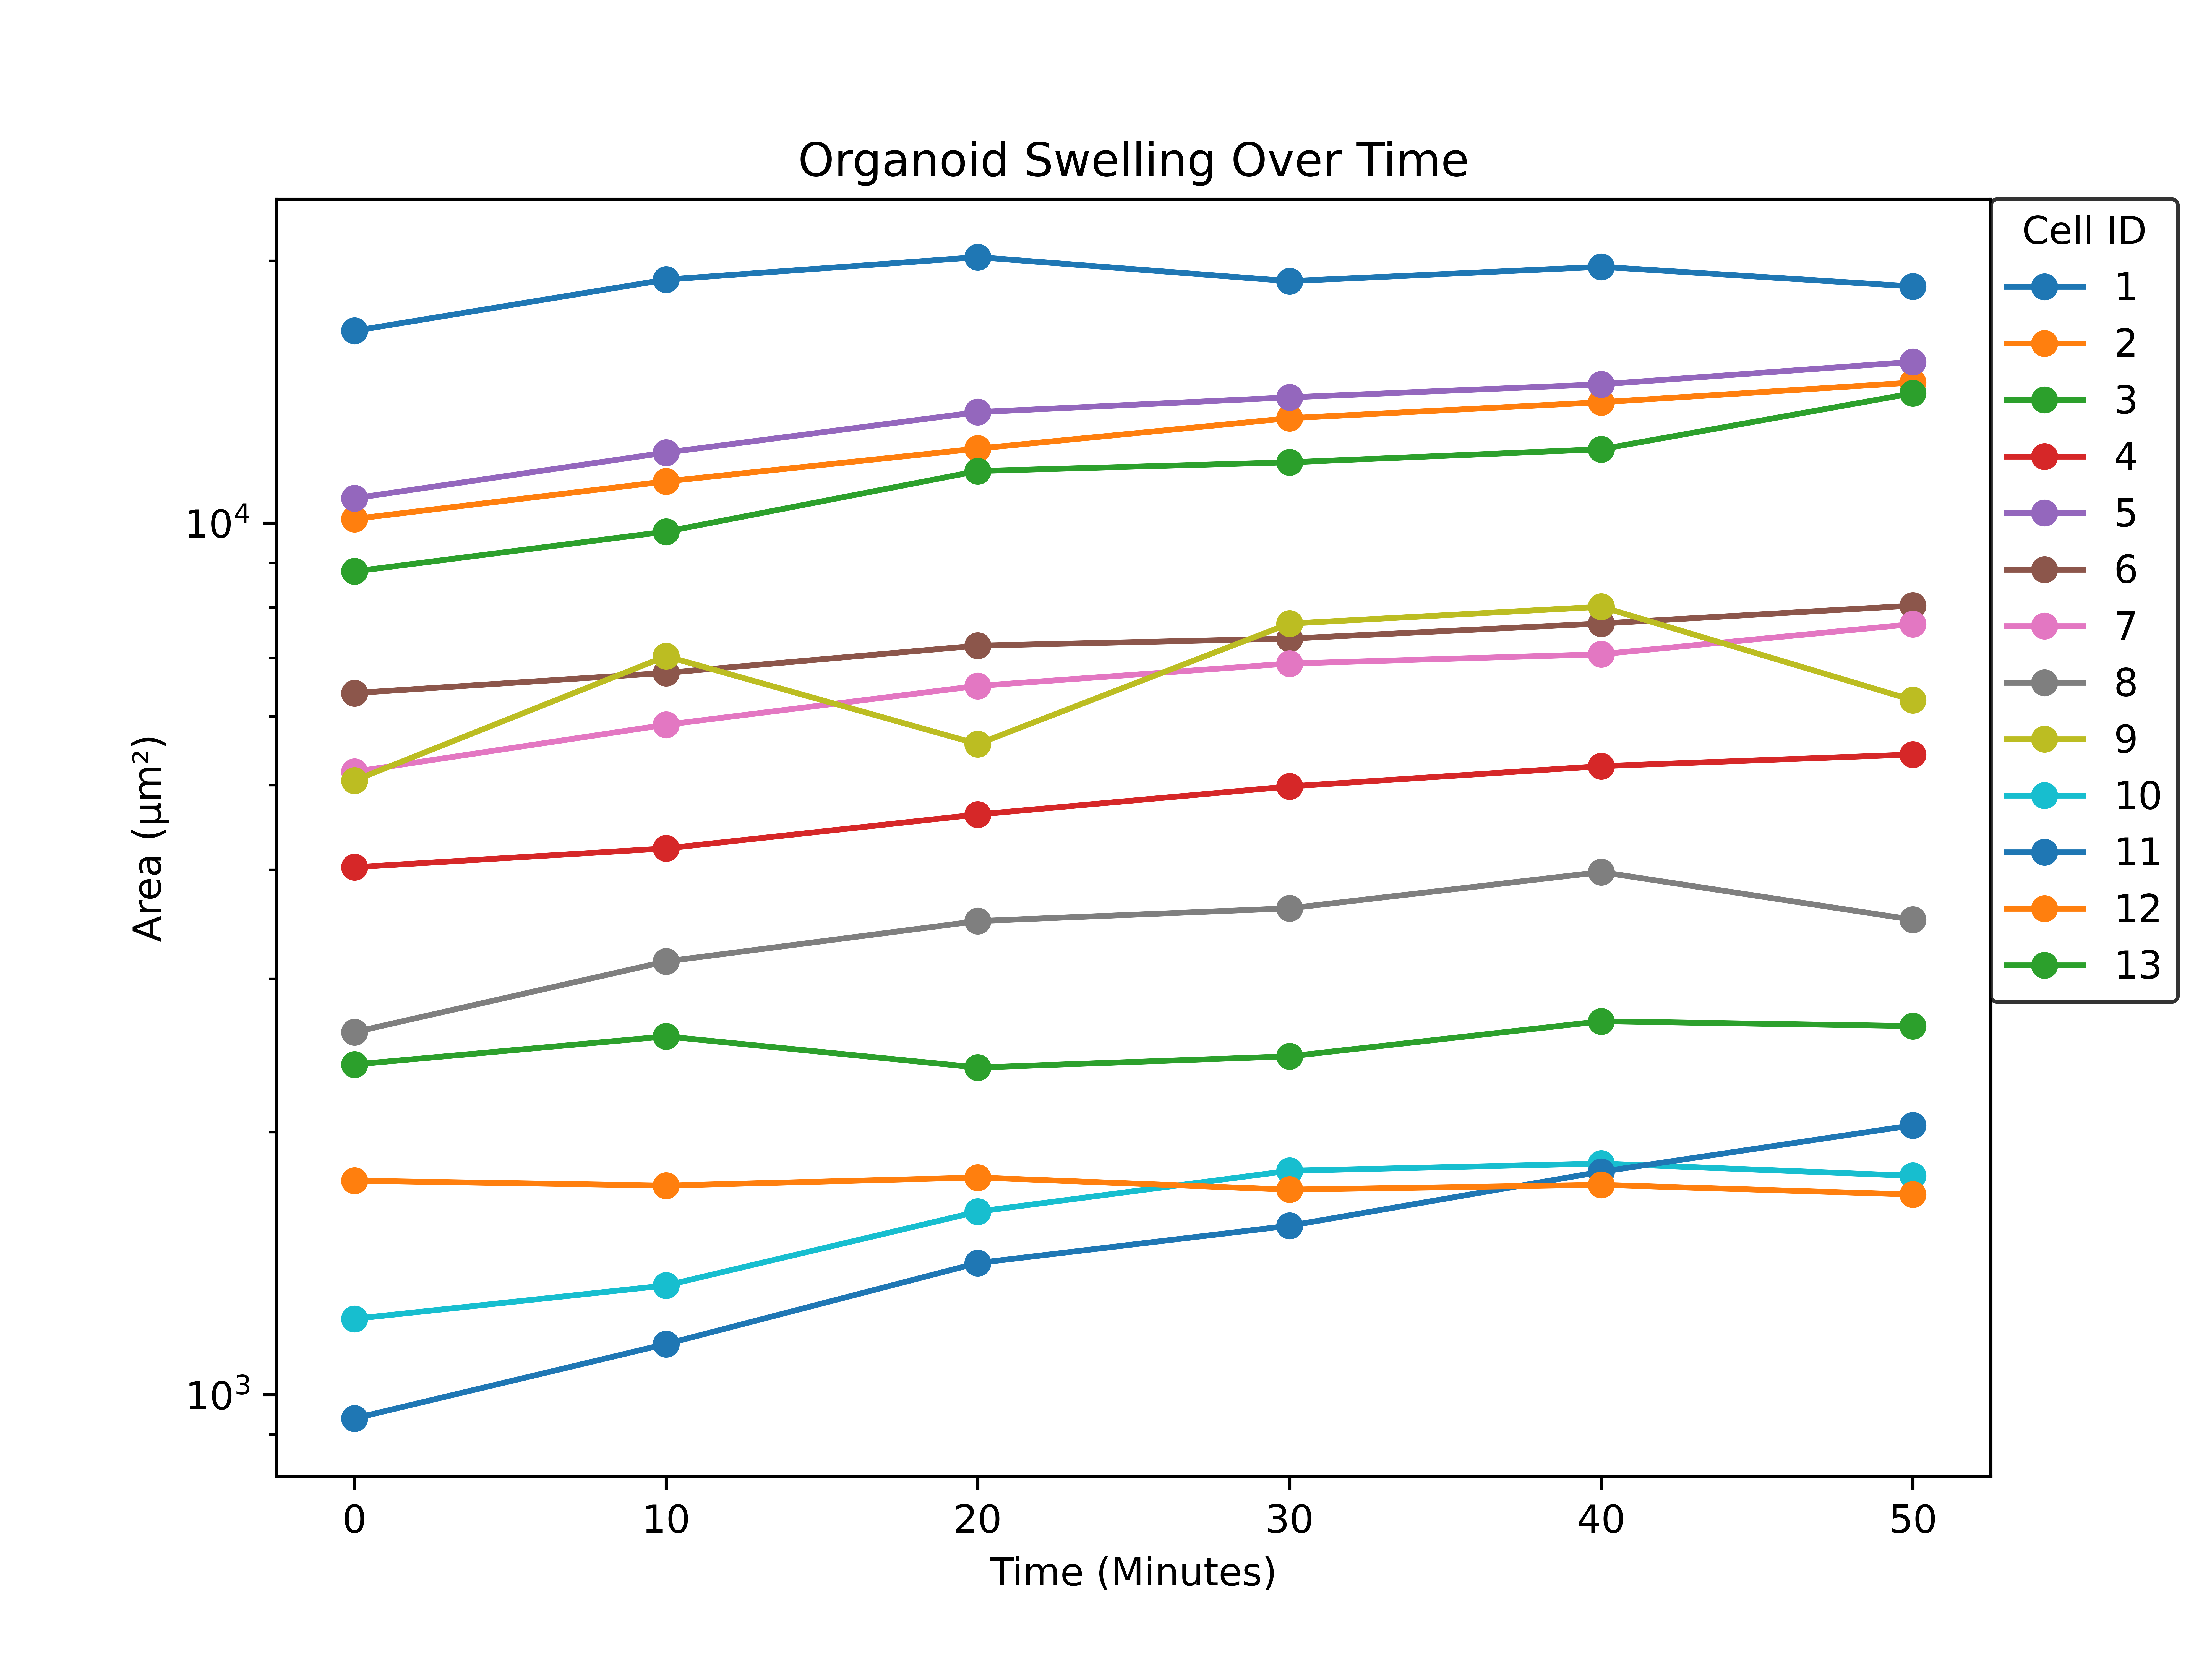

In [19]:
# show cell areas figure
plt.figure()
ax = plt.gca()
for idn, a in areas.items():
    ax.plot(times, a, '-o', label=idn)
plt.title('Organoid Swelling Over Time')
plt.xlabel('Time (Minutes)')
plt.ylabel('Area (μm²)')
# plt.ylim(0, round(max(list(chain.from_iterable(list(areas.values()))))) * 1.2)
plt.legend(loc='upper left')
plt.yscale('log')
plt.legend(handles=ax.get_legend_handles_labels()[0], title="Cell ID",
           bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., edgecolor='black')
plt.savefig(CELL_AREAS_FIG_FILENAME, dpi=DPI, bbox_inches=0)
plt.close(plt.gcf())
Image(CELL_AREAS_FIG_FILENAME, width=750)

In [20]:
k = 'Organoid Swelling Over Time (Normalized to t=0) (%) (per cell ID)'
norm_areas = {idn: list(np.array(a) / a[0] * 100) for idn, a in areas.items()}
columns = list(areas.keys())
columns = list(zip([k] * len(list(areas.keys())), columns))             
columns = pd.MultiIndex.from_tuples(columns) 

rows = times
rows = list(zip(['Time (Minutes)'] * len(times), rows))             
rows = pd.MultiIndex.from_tuples(rows) 

df = pd.DataFrame({(k, idn): a for idn, a in norm_areas.items()}, index=rows, columns=columns)
df.to_csv(CELL_AREAS_NORM_FIG_FILENAME + '.csv')
df.style.set_table_styles([dict(selector='th', props=[('text-align', 'right')])])
display(df)

Organoid Swelling Over Time (Normalized to t=0) (%) (per cell ID)  \
                                                                                 1    
Time (Minutes) 0                                              100.00                  
               10                                             114.49                  
               20                                             121.49                  
               30                                             114.02                  
               40                                             118.43                  
               50                                             112.44                  

                                                                           \
                       2       3       4       5       6       7       8    
Time (Minutes) 0   100.00  100.00  100.00  100.00  100.00  100.00  100.00   
               10  110.43  111.08  105.09  112.84  105.48  113.22  120.55   
               20  120.42  130.36  114.95  125.56  113.34  125.45  134.11   
               30  130.49  133.40  123.78  130.55  115.47  133.08  138.71   
               40  136.11  138.10  130.60  135.13  120.17  136.40  152.65   
               50  143.38  160.09  134.69  143.38  125.98  147.71  134.60   

                                                           
                       9       10      11      12      13  
Time (Minutes) 0   100.00  100.00  100.00  100.00  100.00  
               10  138.84  109.21  121.73   98.70  107.69  
               20  110.10  132.73  150.78  100.83   99.20  
               30  151.35  147.87  166.37   97.66  102.18  
               40  158.24  150.71  191.91   98.91  112.09  
               50  123.63  145.92  216.96   96.41  110.67

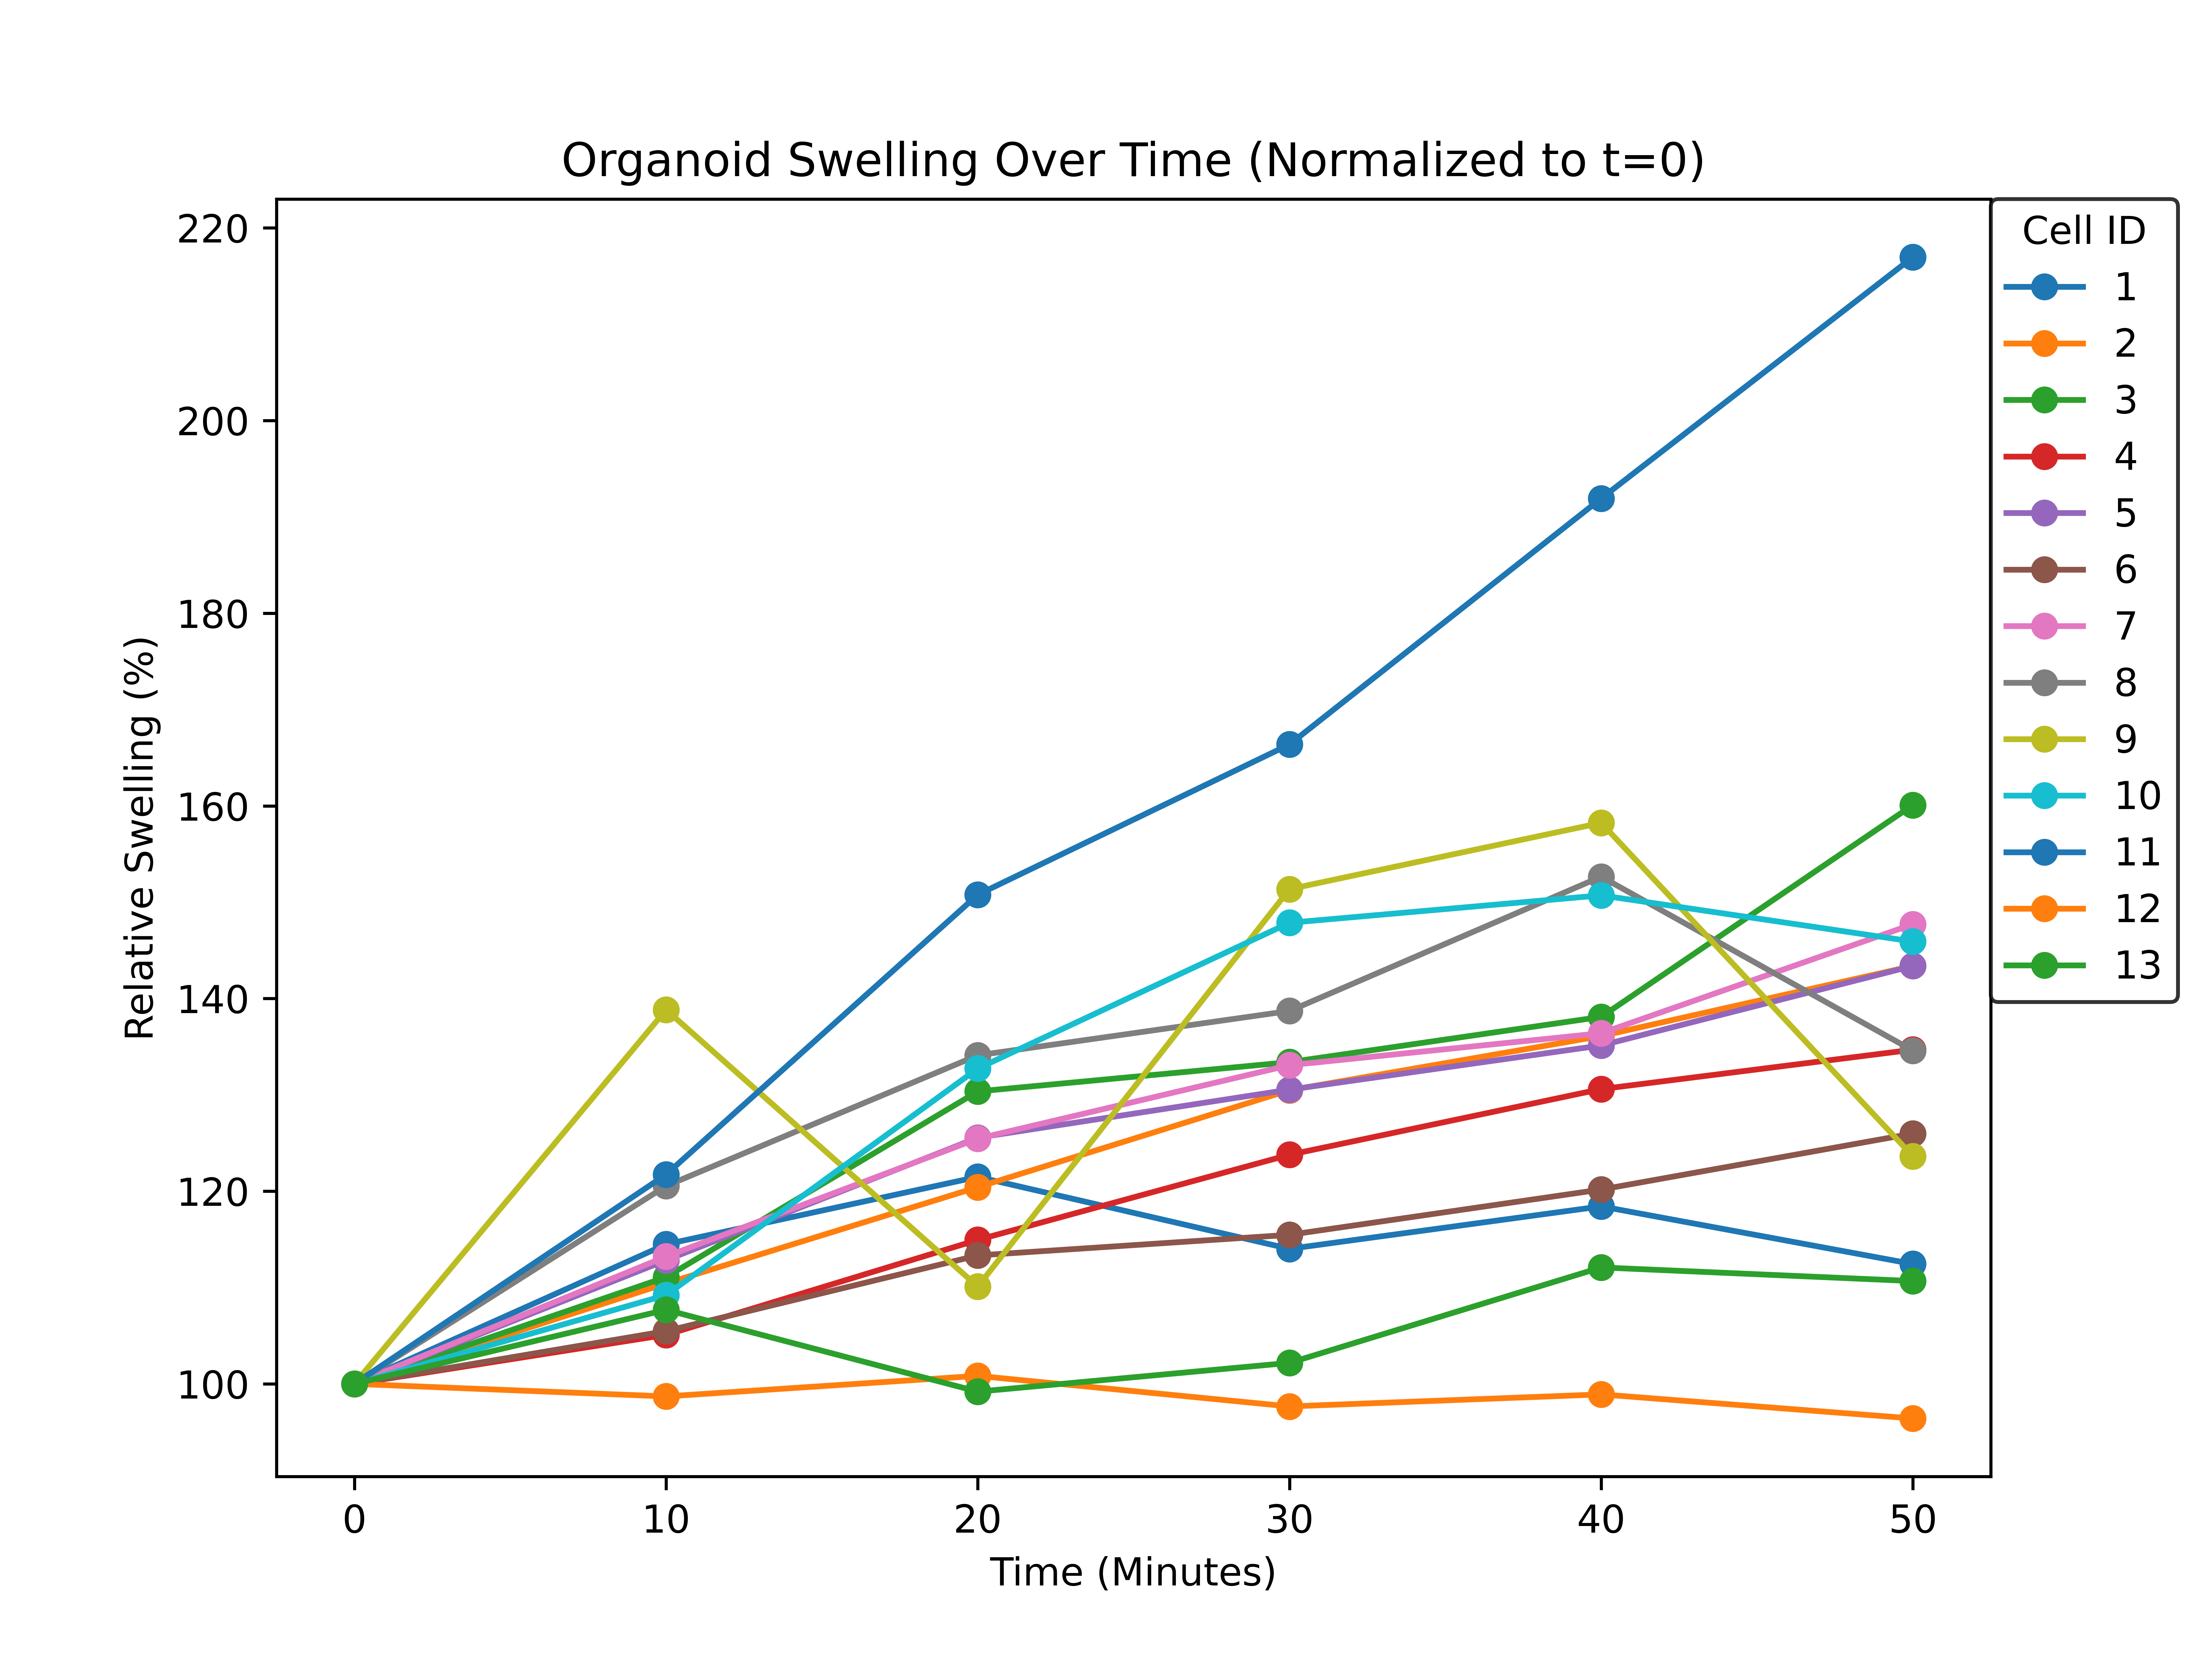

In [21]:
plt.figure()
ax = plt.gca()
for idn, a in norm_areas.items():
    ax.plot(times, a, '-o', label=idn)
plt.title('Organoid Swelling Over Time (Normalized to t=0)')
plt.xlabel('Time (Minutes)')
plt.ylabel('Relative Swelling (%)')
# plt.ylim(0, round(max(list(chain.from_iterable(list(areas.values()))))) * 1.2)
plt.legend(handles=ax.get_legend_handles_labels()[0], title="Cell ID",
           bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., edgecolor='black')
plt.savefig(CELL_AREAS_NORM_FIG_FILENAME, dpi=DPI, bbox_inches=0)
plt.close(plt.gcf())
Image(CELL_AREAS_NORM_FIG_FILENAME, width=750)

In [22]:
aucs = {('Cell ID', idn): np.trapz(a, dx=5) for idn, a in areas.items()}
series = pd.Series(aucs, name='Organoid Swelling Area Under the Curve (μm² Minutes)')
series = series.to_frame()
series.to_csv(AUC_CSV_FILENAME)
series.style.set_table_styles([dict(selector='th', props=[('text-align', 'right')])])
display(series)

Organoid Swelling Area Under the Curve (μm² Minutes)
Cell ID 1                                           477424.12   
        2                                           312936.86   
        3                                           282924.86   
        4                                           119176.46   
        5                                           334039.05   
        6                                           181051.05   
        7                                           163801.01   
        8                                            86396.59   
        9                                           169778.25   
        10                                           40523.06   
        11                                           37048.35   
        12                                           43487.66   
        13                                           62963.44

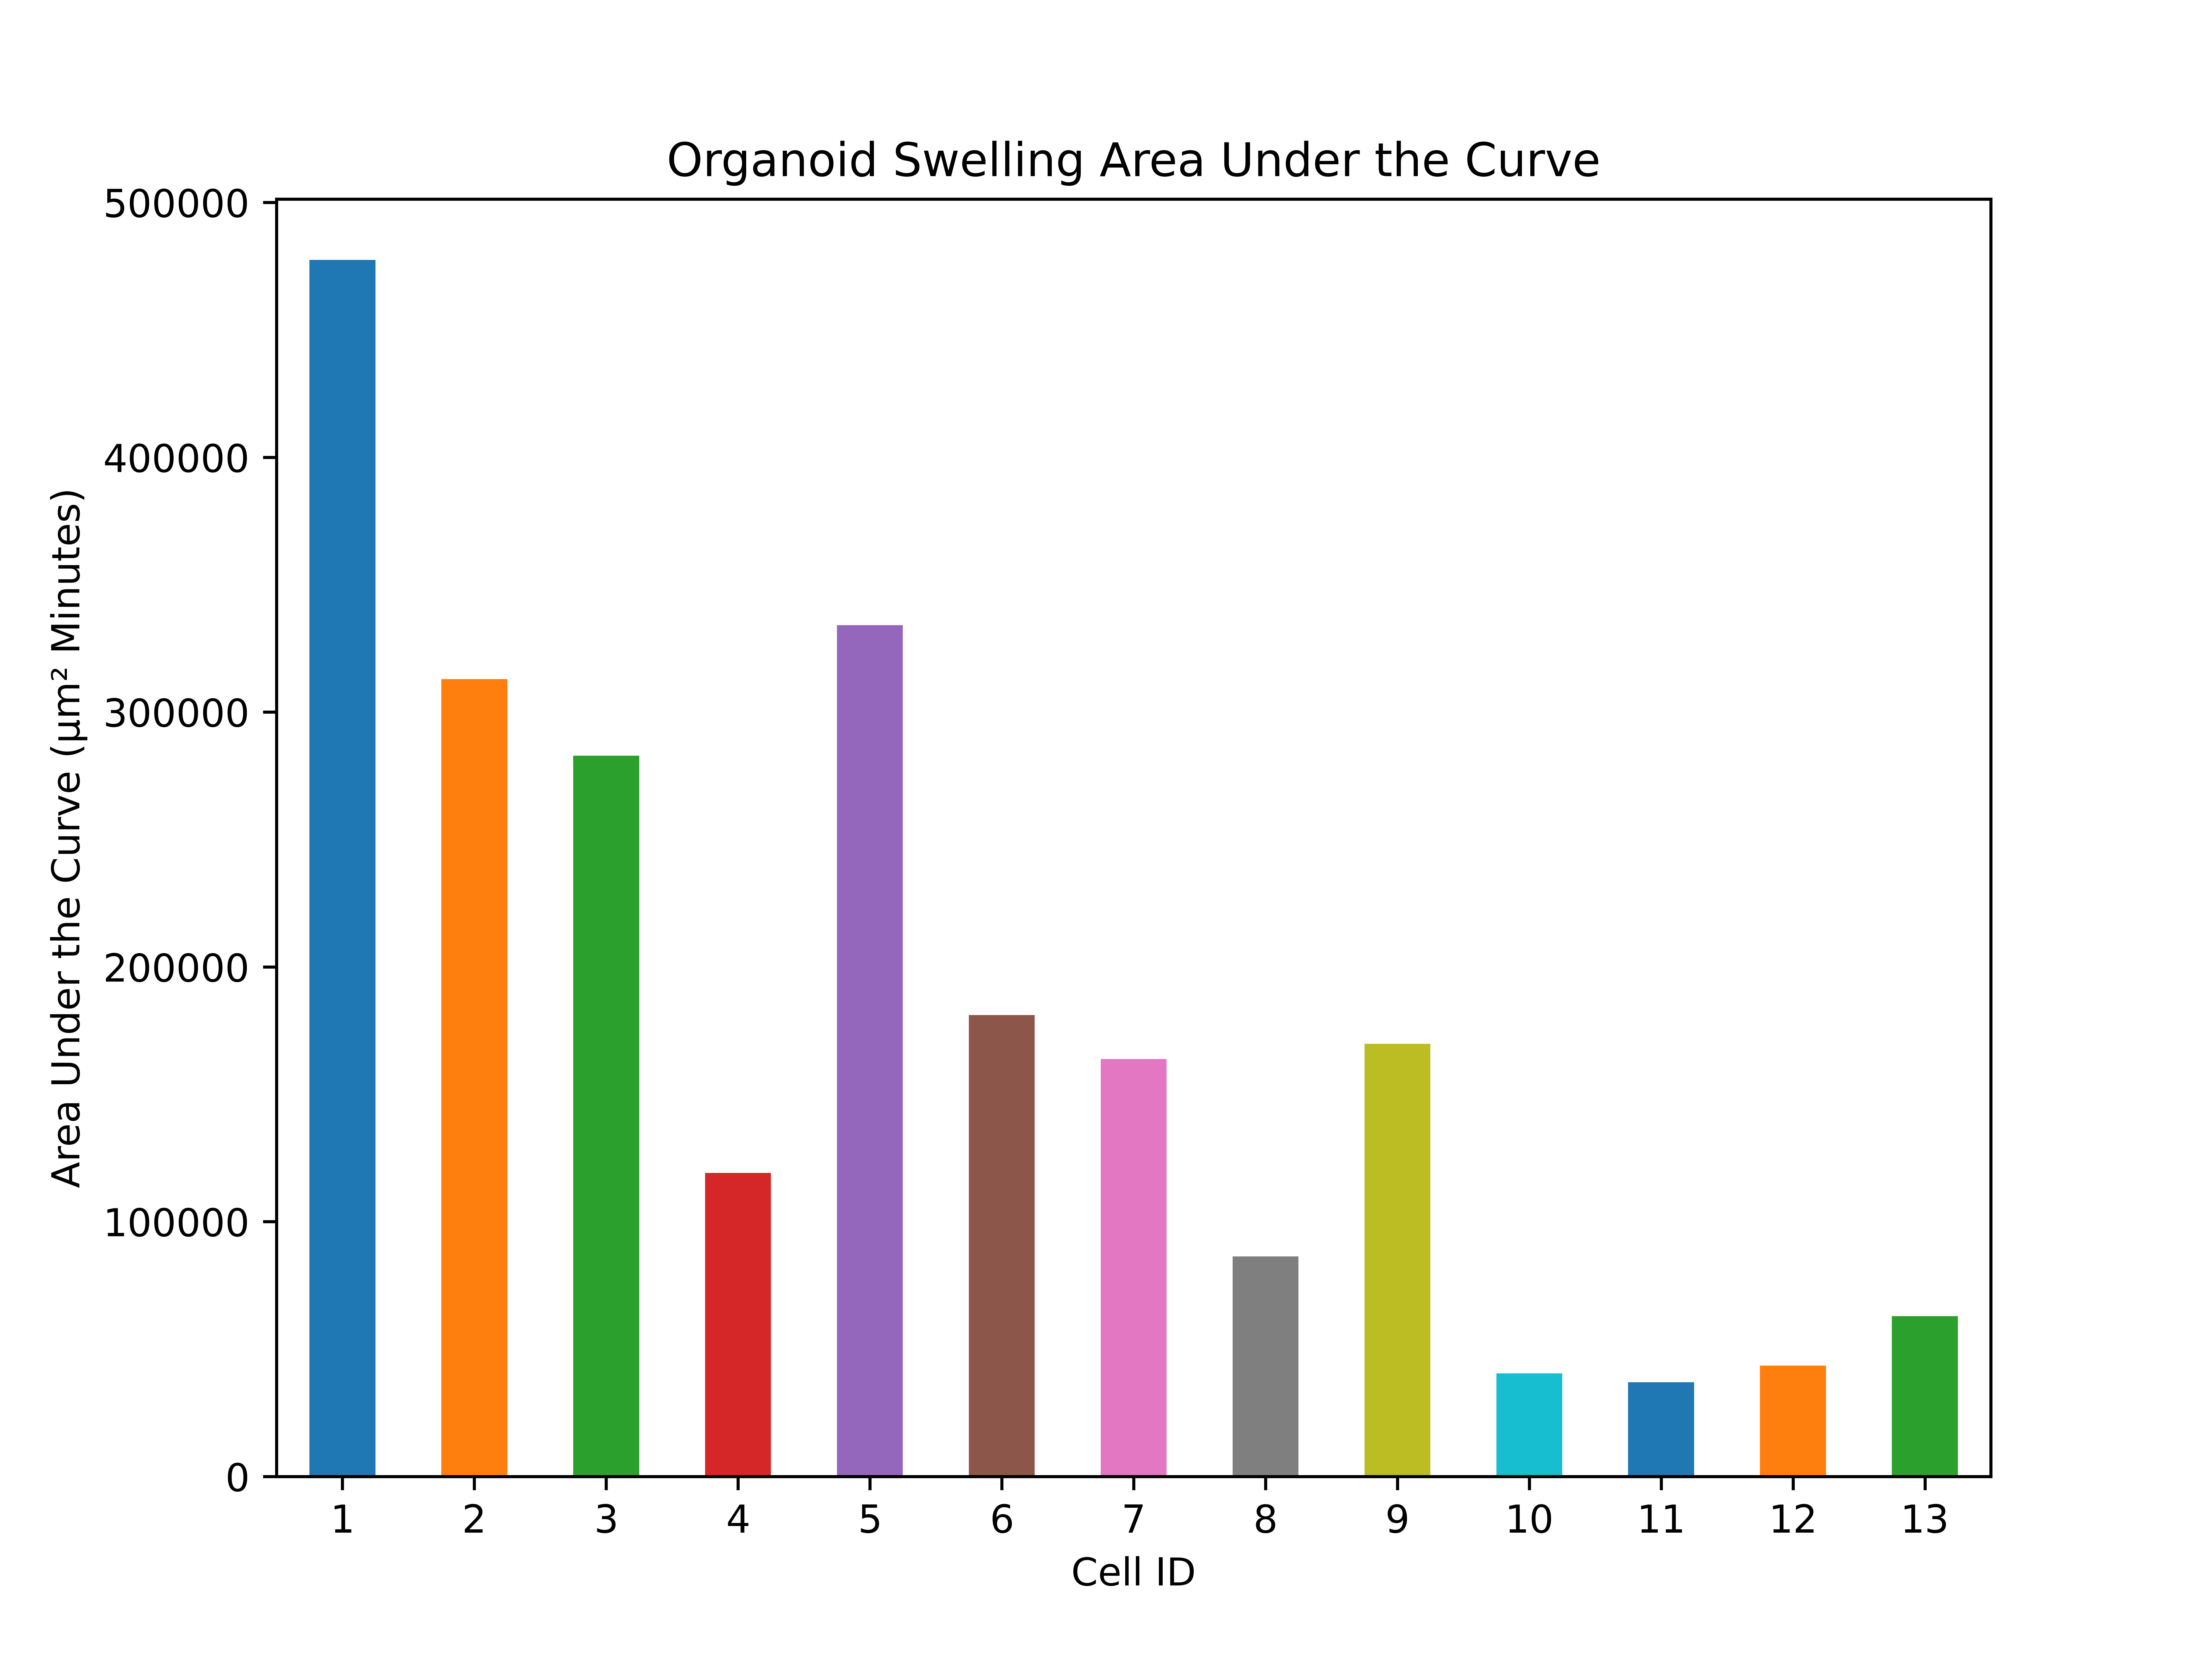

In [23]:
plt.figure()
cmap = plt.cm.tab10
colours = cmap(np.arange(len(areas)) % cmap.N)
ax=pd.Series({idn: np.trapz(a, dx=5) for idn, a in areas.items()}).plot.bar(color=colours)
ax.set_xlabel('Cell ID')
ax.set_ylabel('Area Under the Curve (μm² Minutes)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Organoid Swelling Area Under the Curve')
plt.savefig(AUC_FIG_FILENAME, dpi=DPI, bbox_inches=0)
plt.close(plt.gcf())
Image(AUC_FIG_FILENAME, width=750)

In [24]:
aucs = {('Cell ID', idn): np.trapz(a, dx=5) for idn, a in norm_areas.items()}
series = pd.Series(aucs, name='Organoid Swelling Area Under the Curve (Normalized to t=0) (% Minutes)')
series = series.to_frame()
series.to_csv(AUC_NORM_CSV_FILENAME)
series.style.set_table_styles([dict(selector='th', props=[('text-align', 'right')])])
display(series)

Organoid Swelling Area Under the Curve (Normalized to t=0) (% Minutes)
Cell ID 1                                             2873.21                     
        2                                             3095.65                     
        3                                             3214.88                     
        4                                             2958.83                     
        5                                             3128.81                     
        6                                             2837.25                     
        7                                             3160.06                     
        8                                             3316.56                     
        9                                             3351.70                     
        10                                            3317.42                     
        11                                            3946.39                     
        12                                            2471.53                     
        13                                            2632.46

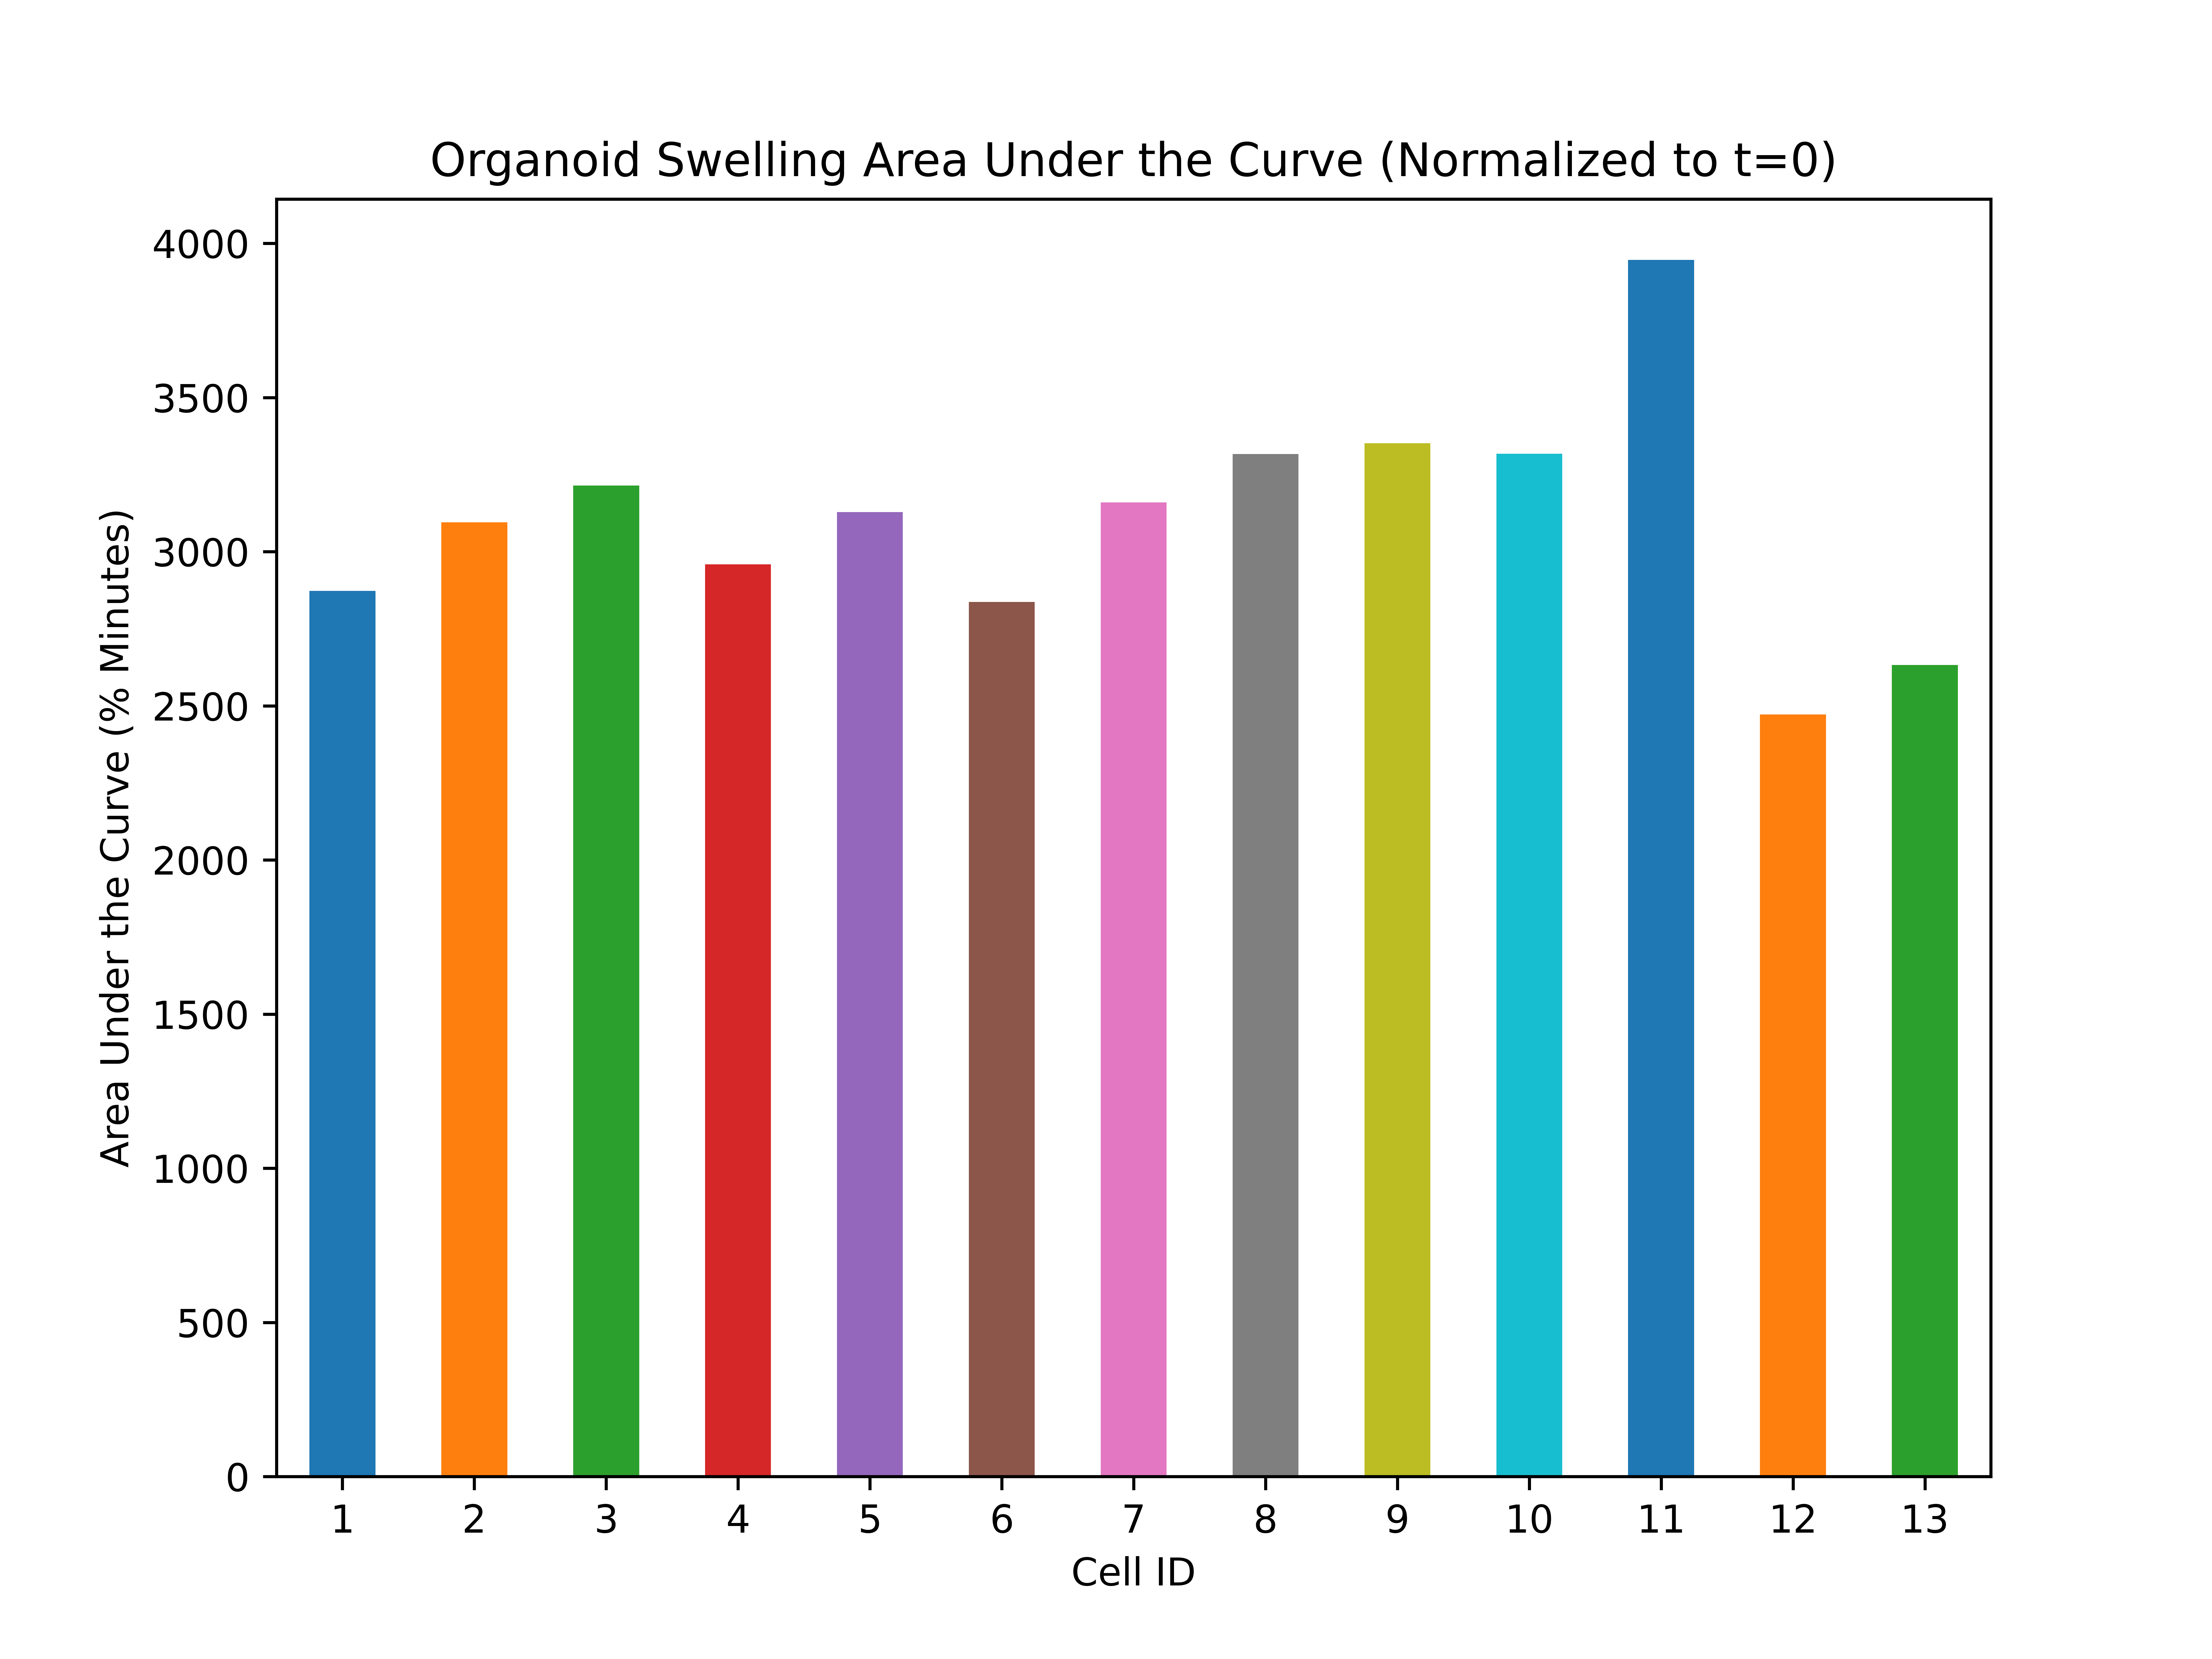

In [25]:
plt.figure()
cmap = plt.cm.tab10
colours = cmap(np.arange(len(areas)) % cmap.N)
ax=pd.Series({idn: np.trapz(a, dx=5) for idn, a in norm_areas.items()}).plot.bar(color=colours)
ax.set_xlabel('Cell ID')
ax.set_ylabel('Area Under the Curve (% Minutes)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Organoid Swelling Area Under the Curve (Normalized to t=0)')
plt.savefig(AUC_NORM_FIG_FILENAME, dpi=DPI, bbox_inches=0)
plt.close(plt.gcf())
Image(AUC_NORM_FIG_FILENAME, width=750)